In [1]:
import numpy as np
import pandas as pd
import glob
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
fault_files = [
    "bearing_fault.csv",
    "bent_shaft.csv",
    "cavitation.csv",
    "flow_pulsation.csv",
    "impeller_imbalance.csv",
    "recirculation.csv",
    "rotor_unbalance.csv",
    "shaft_misalignment.csv"
]

for file in fault_files:
    df = pd.read_csv(file)

In [3]:
def extract_fft_features(signal, fs=1000):
    fft_vals = np.abs(np.fft.fft(signal))
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    mask = freqs >= 0
    fft_vals = fft_vals[mask]
    freqs = freqs[mask]

    bands = [
        (0, 25),
        (25, 50),
        (50, 75),
        (75, 100),
        (100, 150),
        (150, 300)
    ]

    features = []
    for low, high in bands:
        band_energy = np.mean(fft_vals[(freqs >= low) & (freqs < high)])
        features.append(band_energy)

    return features


In [4]:
def extract_time_features(signal):
    return [
        np.mean(signal),
        np.std(signal),
        np.max(signal),
        np.min(signal),
        np.sqrt(np.mean(signal**2))  # RMS
    ]


In [5]:
X = []
y = []

segment_length = 256
overlap = 128

for file in glob.glob("*.csv"):
    df = pd.read_csv(file)

    signal = df["Vibration"].values
    label = os.path.splitext(file)[0]

    for start in range(0, len(signal) - segment_length, overlap):
        segment = signal[start:start + segment_length]

        fft_feats = extract_fft_features(segment)
        time_feats = extract_time_features(segment)

        features = fft_feats + time_feats

        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Total samples:", len(y))
print("Feature dimension:", X.shape[1])


Total samples: 304
Feature dimension: 11


In [6]:
le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [8]:
ann = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    max_iter=1500,
    random_state=42
)

ann.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(64, 32, 16), max_iter=1500, random_state=42)

In [10]:
y_pred = ann.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9078947368421053


In [11]:
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))


                    precision    recall  f1-score   support

     bearing_fault       1.00      1.00      1.00         9
        bent_shaft       0.89      0.89      0.89         9
        cavitation       0.67      0.80      0.73        10
    flow_pulsation       1.00      0.90      0.95        10
impeller_imbalance       1.00      1.00      1.00        10
     recirculation       1.00      1.00      1.00         9
   rotor_unbalance       0.78      0.70      0.74        10
shaft_misalignment       1.00      1.00      1.00         9

          accuracy                           0.91        76
         macro avg       0.92      0.91      0.91        76
      weighted avg       0.91      0.91      0.91        76



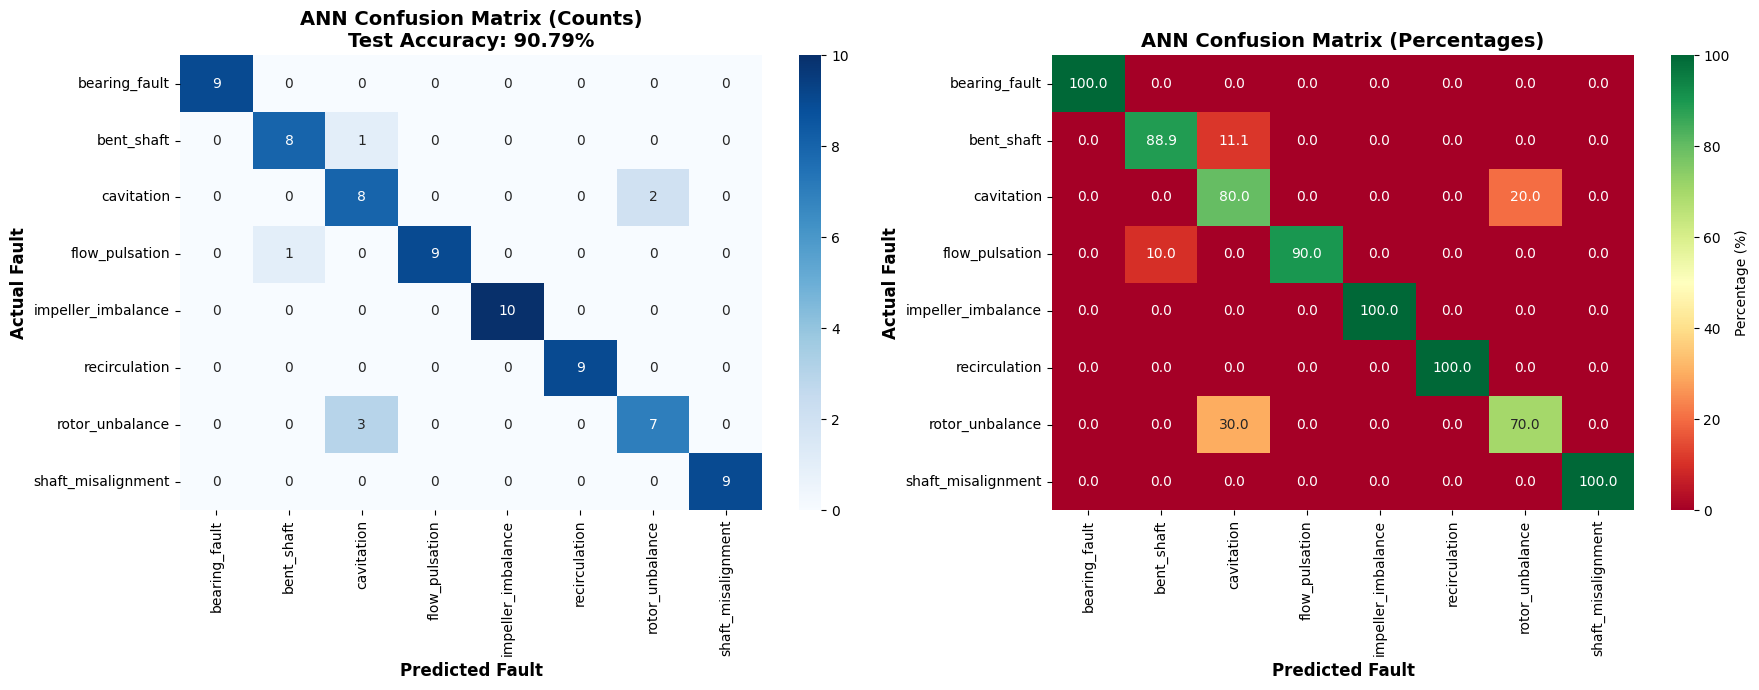

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# --- Convert to class labels if needed ---
# If y_test is one-hot encoded:
if len(y_test.shape) > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test

# If ANN output is probabilities:
if len(y_pred.shape) > 1:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred

# --- Compute Confusion Matrix ---
cm = confusion_matrix(y_test_classes, y_pred_classes)

# --- Compute Accuracy ---
accuracy = accuracy_score(y_test_classes, y_pred_classes) * 100

# --- Percentage Matrix ---
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ==============================
# LEFT: COUNTS
# ==============================
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    ax=axes[0]
)

axes[0].set_title(
    f"ANN Confusion Matrix (Counts)\nTest Accuracy: {accuracy:.2f}%",
    fontsize=14,
    fontweight="bold"
)
axes[0].set_xlabel("Predicted Fault", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Actual Fault", fontsize=12, fontweight="bold")

# ==============================
# RIGHT: PERCENTAGES
# ==============================
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    ax=axes[1],
    cbar_kws={'label': 'Percentage (%)'}
)

axes[1].set_title(
    "ANN Confusion Matrix (Percentages)",
    fontsize=14,
    fontweight="bold"
)
axes[1].set_xlabel("Predicted Fault", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Actual Fault", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("ANN_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

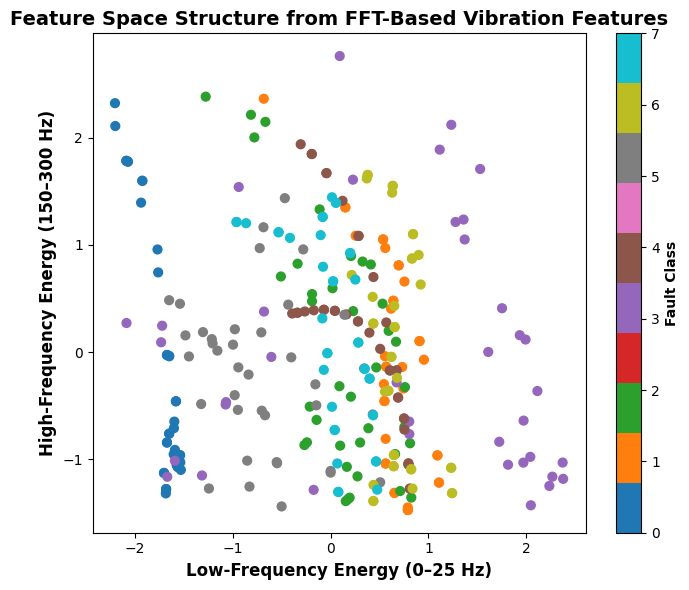

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Use two meaningful FFT bands
low_energy = X[:, 0]   # e.g., 0–25 Hz
high_energy = X[:, 5]  # e.g., 150–300 Hz

plt.figure(figsize=(7, 6))

scatter = plt.scatter(
    low_energy,
    high_energy,
    c=y,
    cmap="tab10",
    s=40
)

plt.xlabel("Low-Frequency Energy (0–25 Hz)", fontsize=12, fontweight="bold")
plt.ylabel("High-Frequency Energy (150–300 Hz)", fontsize=12, fontweight="bold")
plt.title("Feature Space Structure from FFT-Based Vibration Features", fontsize=14, fontweight="bold")

cbar = plt.colorbar(scatter)
cbar.set_label("Fault Class", fontweight="bold")

plt.tight_layout()
plt.show()


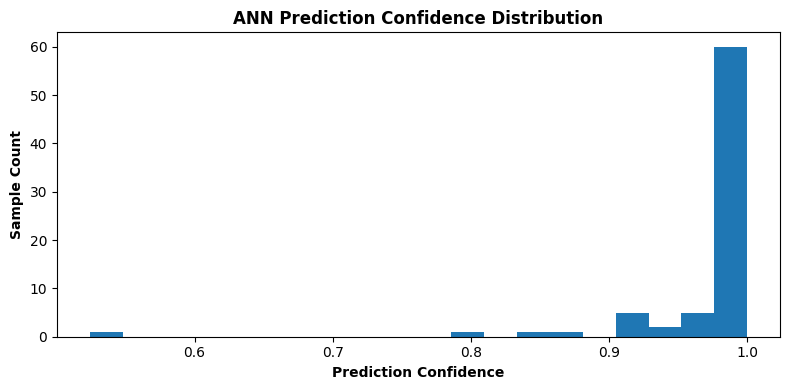

In [13]:
y_prob = ann.predict_proba(X_test)

plt.figure(figsize=(8, 4))
plt.hist(np.max(y_prob, axis=1), bins=20)

plt.xlabel("Prediction Confidence", fontweight="bold")
plt.ylabel("Sample Count", fontweight="bold")
plt.title("ANN Prediction Confidence Distribution", fontweight="bold")
plt.tight_layout()
plt.show()
